```
This software is part of GPU Ocean. 

Copyright (C) 2018, 2019 SINTEF Digital
Copyright (C) 2018 Norwegian Meteorological Institute

This notebook implements a test to investigate power consumption for
different block sizes for selected numerical schemes.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Power consumption: Block Size Experiment

This notebook runs some iterations of each of different numerical schemes on a range of different CUDA block sizes.
The 'nvidia-smi' application runs in the background and records various parameters, such as GPU power consumption, core temperature, etc, and reports these parameters to a log file. 
The performance is simultaneously reported in a text file.
These parameters are later read and processed to obtain the most efficient block sizes on the GPU on your given system.

### To look at the results shown in the paper
Execute the cells below to read the results obtained for the paper and reproduce the power consumption results.

### To find your own power consumption
Comment out the second to last line in the second cell (which overwrites the `test_filename` variable) in order to produce your own benchmark results. Optimal block sizes are typically not the same across different GPUs, so your results might differ from those reported in the paper.


In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import subprocess
import os
import socket
import os.path
import time
from tempfile import TemporaryFile


import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [2]:
# Generate unique folder name
folder_name = os.path.abspath("power_block_size_0")
folder_test = 0
while (os.path.isdir(folder_name)):

    folder_name = os.path.abspath("power_block_size_" + str(folder_test))
    folder_test += 1
    
    
#Use the existing file, do not generate new data
#folder_name = os.path.abspath("power_block_size_0")
print("Storing data in folder " + folder_name)
main_log_filename='power_consumptions.log'

Storing data in folder /home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/power_block_size_9


In [3]:
# Specify python command:
#python = "python"

python = 'python3'
if socket.gethostname().startswith('havahol'):
    python = "/home/havahol/miniconda3/envs/gpuocean/bin/python"
shell = False
print(python)

/home/havahol/miniconda3/envs/gpuocean/bin/python


In [4]:
# benchmark duration parameter
steps_per_iteration_benchmark = 100

# nvidia-smi parameters:
smi_loop_ms = 50
sleep_duration_sec = 3

# derived parameters:
smi_entries_per_sec = round(1000/smi_loop_ms) # Number of smi log entries per second
num_entries_to_ignore = smi_entries_per_sec*sleep_duration_sec 



In [5]:
def runBenchmark(folder_name):
    #sim = np.array(["FBL", "CTCS", "KP", "CDKLM"])
    #sim = np.array(["CDKLM", "CTCS", "FBL", "KP"])
    sim = np.array(["CDKLM"])
    #block_width = np.array([4, 8, 12, 16, 24, 32])
    #block_height = np.array([4, 8, 12, 16, 24, 32])
    block_width = np.array([12, 16, 24])#, 8]), #12, 16, 24, 32])
    block_height = np.array([12, 16, 24])#, 8]) #, 12, 16, 24, 32])
    #block_width=list(range(2,33,1))
    #block_height=list(range(2,33,1))
    
    print("Running with the following:")
    print('Sims: ' + str(sim))
    print("Widths: " + str(block_width))
    print("Heights: " + str(block_height))

    block_width, block_height = np.meshgrid(block_width, block_height)
    
    test_filename = os.path.join(folder_name, main_log_filename)
    
    
    with open(test_filename, 'w') as test_file:
        for k in range(len(sim)):
            test_file.write("##########################################################################\n")
            test_file.write("Using simulator " + sim[k] + ".\n")
            test_file.write("##########################################################################\n")

            
            for j in range(block_width.shape[1]):
                for i in range(block_width.shape[0]):
                    

                    start_info = sim[k] + " [{:02d} x {:02d}]\n".format(block_width[i,j], block_height[i,j])
                    test_file.write("=========================================\n")
                    test_file.write(start_info)
                    test_file.write("-----------------------------------------\n")
                    print('\n'+start_info)
                    
                    with TemporaryFile() as tmpfile:

                        # Start nvidia-smi to file f
                        smi_report_filename = 'nvidia_smi_w'+str(block_width[i,j])+'_h'+str(block_height[i,j])+'.log'
                        smi_report_file = os.path.join(folder_name, smi_report_filename)

                        print('')
                        smi_cmd = [
                            'nvidia-smi',
                            '--query-gpu=timestamp,'+\
                                        'temperature.gpu,'+\
                                        'memory.free,'+\
                                        'fan.speed,'+\
                                        'utilization.gpu,'+\
                                        'power.draw,'+\
                                        'clocks.current.sm,'+\
                                        'clocks.current.graphics,'+\
                                        'clocks.current.memory',
                            '--format=csv',
                            '--loop-ms='+str(smi_loop_ms),
                            '--filename='+str(smi_report_file)
                        ]
                        test_file.write("=========================================\n")
                        test_file.write('nvidia_smi_file='+str(smi_report_file)+', ')
                        test_file.write('nvidia_smi_cmd='+str(smi_cmd)+', ')
                        print('nvidia_smi_file='+str(smi_report_file))

                        smi_process = subprocess.Popen(smi_cmd, shell=shell, 
                                                       stdin=subprocess.PIPE, 
                                                       stdout=tmpfile, 
                                                       stderr=subprocess.STDOUT)


                        # Sleep 3 sec
                        time.sleep(sleep_duration_sec)

                        # Run benchmark
                        print('starting benchmark... ', end='')
                        tic = time.time()

                        cmd = [ python, "run_benchmark.py", 
                               "--block_width", str(block_width[i,j]), "--block_height", str(block_height[i,j]),
                               "--simulator", sim[k], #, "--nx", "100", "--ny", "100", 
                               "--steps_per_download", str(steps_per_iteration_benchmark), 
                               "--iterations", "10"]
                        p = subprocess.Popen(cmd, shell=shell, 
                                             stdin=subprocess.PIPE, 
                                             stdout=subprocess.PIPE, 
                                             stderr=subprocess.STDOUT)

                        # process output from run benchmark
                        output = p.stdout.read()
                        test_file.write(str(output) + "\n")
                        test_file.write("=========================================\n")
                        test_file.write("\n")
                        print('benchmark finished!')

                        toc = time.time()

                        # Sleep 3 sec
                        time.sleep(sleep_duration_sec)

                        # Kill nvidia-smi process.
                        smi_process.terminate()
                    
                    
                    infostr = sim[k] + " [{:02d} x {:02d}] completed in {:.02f} s\n".format(block_width[i,j], block_height[i,j], (toc-tic))
                    test_file.write(infostr)
                    print(infostr)
                    
            test_file.write("\n\n\n")
            test_file.flush()
            os.fsync(test_file)

# Generate unique folder name
folder_name = os.path.abspath("power_block_size_0")
folder_test = 0
while (os.path.isdir(folder_name)):

    folder_name = os.path.abspath("power_block_size_" + str(folder_test))
    folder_test += 1
            

folder_name = os.path.abspath("power_block_size_14")
if not (os.path.isdir(folder_name)):
    os.mkdir(folder_name)
    runBenchmark(folder_name)
    print('Done!')
else:
    print("Using existing run in " + folder_name)

Running with the following:
Sims: ['CDKLM']
Widths: [12 16 24]
Heights: [12 16 24]

CDKLM [12 x 12]


nvidia_smi_file=/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/power_block_size_9/nvidia_smi_w12_h12.log
starting benchmark... benchmark finished!
CDKLM [12 x 12] completed in 11.16 s


CDKLM [12 x 16]


nvidia_smi_file=/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/power_block_size_9/nvidia_smi_w12_h16.log
starting benchmark... benchmark finished!
CDKLM [12 x 16] completed in 11.11 s


CDKLM [12 x 24]


nvidia_smi_file=/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/power_block_size_9/nvidia_smi_w12_h24.log
starting benchmark... benchmark finished!
CDKLM [12 x 24] completed in 11.23 s


CDKLM [16 x 12]


nvidia_smi_file=/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/power_block_size_9/nvidia_smi_w16_h12.log
starting benchmark... benchmark finished!
CDK

In [6]:
dataframe_columns = ['simulator', 'block_width', 'block_height', 
                     'megacells',
                     'max_temperature', 'min_temperature', 'cumsum_temperature',
                     'max_power', 'min_power', 'total_power', 'mean_power',
                     'max_utilization', 'min_utilization', 'mean_utilization',
                     ]
labels = ['simulator', 'block_width', 'block_height', 
          'Megacells/s',
          'Max temperature [C]', 'Min temperature [C]', 'Accumulated temperature [Cs]',
          'Max power consumption [W]', 'Min power consumption [W]', 
          'Energy consumption [J]', 'Mean power consumption [W]',
          'Max GPU utilization [%]', 'Min GPU utilization [%]', 'Mean GPU utilization [%]'
         ]


def read_smi_file(smi_log_file):
    smi_log = pd.read_csv(smi_log_file)
    temp_key  = 'temperature.gpu'
    power_key = 'power.draw [W]'
    utilization_key = 'utilization.gpu [%]'
    fan_key = 'fan.speed [%]'
    
    # Remove whitespaces from column names:
    smi_log.rename(columns=lambda x: x.strip(), inplace=True)

    #for col in smi_log.columns:
    #    print(col)
        
    # Parse missing values
    smi_log = smi_log.replace(' [Not Supported]', np.NaN)
    
    # Helper function for parcing percent values
    def parse_value(df, key, unit):
        if not pd.isnull(df[key].iloc[0]):
            #print('fixing ' + key)
            df[key] = df[key].str.replace(' ','')
            df[key] = df[key].str.replace(unit, '')
            df[key] = pd.to_numeric(smi_log[key])
            
    parse_value(smi_log, utilization_key, '%')
    parse_value(smi_log, fan_key, '%')
    parse_value(smi_log, power_key, 'W')
    
    # Find min and max 
    max_temperature = smi_log[temp_key].max()
    min_temperature = smi_log[temp_key].min()
    min_power_draw  = smi_log[power_key].min()
    max_power_draw  = smi_log[power_key].max()
    min_utilization = smi_log[utilization_key].min()
    max_utilization = smi_log[utilization_key].max()
    
    # temperature*seconds
    all_sum_temperature = smi_log[temp_key].sum()*smi_loop_ms/1000

    # Drop first and last rows
    # This compensates for the sleep commands above.
    smi_log.drop(smi_log.head(num_entries_to_ignore).index,inplace=True)
    smi_log.drop(smi_log.tail(num_entries_to_ignore).index,inplace=True)
    
    cumsum_temperature = smi_log[temp_key].sum()*smi_loop_ms/1000
    
    total_power = smi_log[power_key].sum()*smi_loop_ms/1000
    if np.isnan(max_power_draw) and np.isnan(min_power_draw):
        total_power = np.NaN
    mean_power = smi_log[power_key].mean()
    mean_utilization = smi_log[utilization_key].mean()
        
    df_values = {'max_temperature': max_temperature,
                 'min_temperature': min_temperature,
                 'cumsum_temperature': cumsum_temperature,
                 'max_power': max_power_draw,
                 'min_power': min_power_draw,
                 'total_power': total_power,
                 'mean_power': mean_power,
                 'max_utilization': max_utilization,
                 'min_utilization': min_utilization,
                 'mean_utilization': mean_utilization
                }
    
    return df_values


def getData(filename):
    # State variables
    simulator = None
    block_width = None
    megacells = None
    block_height = None
    #max_temperature = None
    #min_temperature = None
    #cumsum_temperature = None
    #power_draw = None
    
    
    df = pd.DataFrame(columns = dataframe_columns)
    
    with open(filename) as origin_file:
        for line in origin_file:
            line = str(line)
            
            # Find simulator
            match = re.match('Using simulator (.+)\.', line)
            if match:
                simulator = match.group(1)
                
            if simulator == None:
                continue

            # Find block size
            match = re.match(simulator + ' \[(\\d+) x (\\d+)\]$', line)
            if match:
                block_width = match.group(1)
                block_height = match.group(2)
                
            # Find simulator megacells
            match = re.match('.*Maximum megacells: (\\d+(\.\\d+)?)', line)
            if match:
                megacells = match.group(1)
                
            # Find nvidia-smi report
            match = re.match('nvidia_smi_file=(.+).log,', line)
            if match:
                smi_log_file = os.path.abspath(match.group(1)+'.log')
                
                df_entries = {'simulator': simulator,
                              'block_width': block_width,
                              'block_height': block_height,
                              'megacells': megacells}
                
                df_smi_entries = read_smi_file(smi_log_file)
                df_entries.update(df_smi_entries)
                
                df = df.append(df_entries , ignore_index=True)
                
                
                
                
                block_width = None
                block_height = None
                #max_temperature = None 
                #min_temperature = None
                #cumsum_temperature = None
                megacells = None
                #simulator = None
            
    return df

main_log_file = os.path.join(folder_name, main_log_filename)
df = getData(main_log_file)
df


,simulator,block_width,block_height,megacells,max_temperature,min_temperature,cumsum_temperature,max_power,min_power,total_power,mean_power,max_utilization,min_utilization,mean_utilization
0,CDKLM,12,12,436.41360827,47,35,477.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CDKLM,12,16,438.68348579,50,41,520.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CDKLM,12,24,422.55754246,53,47,566.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CDKLM,16,12,462.73952592,56,50,555.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CDKLM,16,16,424.58005934,57,50,612.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,CDKLM,16,24,435.35725903,59,54,630.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,CDKLM,24,12,442.87922944,61,55,629.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,CDKLM,24,16,442.20927459,61,54,638.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,CDKLM,24,24,404.76607576,62,58,702.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN


['12' '16' '24']
Plotting megacells
CDKLM
         12       16       24
12  436.414  438.683  422.558
16   462.74   424.58  435.357
24  442.879  442.209  404.766
         12       16       24
12  436.414  438.683  422.558
16   462.74   424.58  435.357
24  442.879  442.209  404.766
Maximum=462.74
Minimum=404.77
Mean=434.47
/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/power_block_size_9/megacells_CDKLM.pdf
Plotting max_temperature
CDKLM
    12  16  24
12  47  50  53
16  56  57  59
24  61  61  62
    12  16  24
12  47  50  53
16  56  57  59
24  61  61  62
Maximum=62.00
Minimum=47.00
Mean=56.22
/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/power_block_size_9/max_temperature_CDKLM.pdf
Plotting min_temperature
CDKLM
    12  16  24
12  35  41  47
16  50  50  54
24  55  54  58
    12  16  24
12  35  41  47
16  50  50  54
24  55  54  58
Maximum=58.00
Minimum=35.00
Mean=49.33
/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/

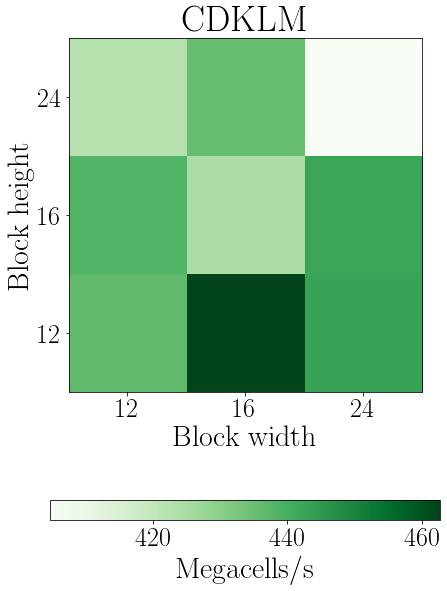

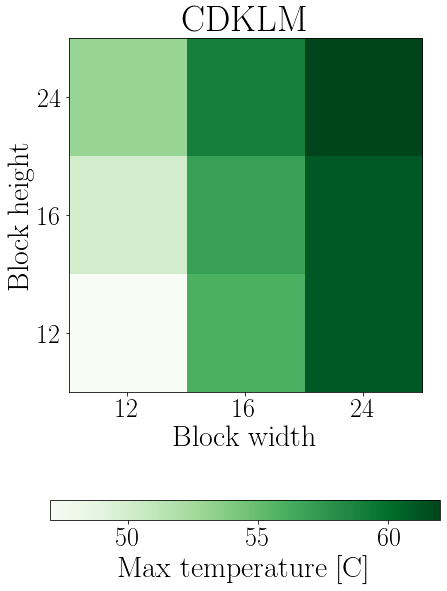

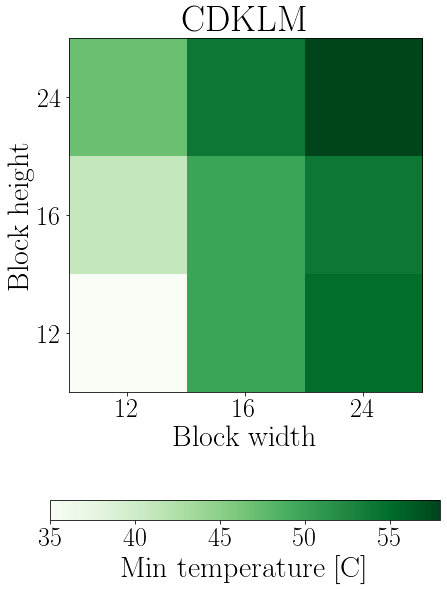

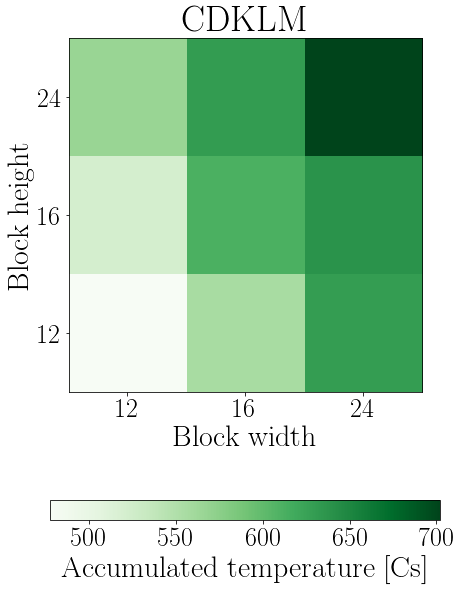

In [7]:
simulators = np.unique(df['simulator'])
block_widths = np.unique(df['block_width'])
block_heights = np.unique(df['block_width'])

print(block_widths)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#fields = ['simulator', 
#          'block_width', 'block_height', 'megacells',
#          'max_temperature', 'min_temperature', 'cumsum_temperature']
#          
#labels = ['simulator', 
#          'block_width', 'block_height', 'Megacells/s',
#          'Max temperature [C]', 'Min temperature [C]', 'Accumulated temperature [Cs]']


def plot_result(all_df, field_id):
    
    assert(field_id > 2), 'field_id must take values between 3 and '+str(len(labels)-1)
    assert(field_id < len(labels)), 'field_id must take values between 3 and '+str(len(labels)-1)
    
    print('Plotting ' + str(dataframe_columns[field_id]))
    
    for simulator in simulators:
        print(simulator)
        data = all_df[['simulator', 
                       'block_width', 'block_height', 
                       dataframe_columns[field_id]]].to_numpy()
        
        df = pd.DataFrame(index=block_widths, columns=block_heights)
        
        # Pick this simulator data only and sort into a dataframe
        columns = data[:,0] == simulator
        all_nan = True
        for record in data[columns]:
            block_width = record[1]
            block_height = record[2]
            values = np.float32(record[3])
            df[block_height][block_width] = values
            if not np.isnan(values):
                all_nan = False
            
        print(df)
        if all_nan:
            print('All values are NaN - nothing to plot')
            return

        maximum = np.nanmax(df.values)
        minimum = np.nanmin(df.values)
        mean = np.nanmean(df.values)
        print(df)
        print("Maximum={:.2f}".format(maximum))
        print("Minimum={:.2f}".format(minimum))
        print("Mean={:.2f}".format(mean))

        # Plot dataframe
        x = df.index.values.astype(np.int)
        y = df.columns.values.astype(np.int)
        z = np.transpose(df.values.astype(np.float32))

        fontsize=30
        fig = plt.figure(figsize=(7,10))
        ax = fig.add_subplot(111)
        img = ax.imshow(z, origin='lower', cmap=cm.Greens, interpolation="None")

        plt.xticks( range(len(x)), x, fontsize=fontsize-4)
        ax.set_xlabel('Block width', fontsize=fontsize)
        plt.yticks( range(len(y)), y, fontsize=fontsize-4)
        ax.set_ylabel('Block height', fontsize=fontsize)

        cb = plt.colorbar(img, orientation="horizontal", pad=0.2)
        cb.ax.tick_params(labelsize=fontsize-4)
        #cb.ax.set_ylabel('Megacells/s')#, rotation=270)
        cb.set_label(labels[field_id], fontsize=fontsize)#, labelpad=-40, y=0.45)


        fig_filename = dataframe_columns[field_id]+'_'+simulator+'.pdf'
        fig_file = os.path.join(folder_name, fig_filename)
        #plt.title(simulator + " [megacells/s]", fontsize=fontsize+6)
        plt.title(simulator, fontsize=fontsize+6)
        fig.savefig(fig_file)
        print(fig_file)
        
          
for field_id in range(3,len(dataframe_columns)):
    plot_result(df, field_id)

In [8]:
print(folder_name)

/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/power_block_size_9


In [9]:
a1 = [1, 2,3]
a2 = [4,6,67]
a1+a2

[1, 2, 3, 4, 6, 67]

In [10]:
df_base_entries = {'simulator': 1,
                                   'block_width': 2,
                                   'block_height': 3,
                                   'megacells': 4}
df_base_entries.update({'something': 1234})
df_base_entries

{'simulator': 1,
 'block_width': 2,
 'block_height': 3,
 'megacells': 4,
 'something': 1234}

In [11]:
percent = ' 37 %'
percent = percent.replace(' ', '').replace('%', '')
int(percent)

37

In [12]:
read_smi_file('/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/prototypes/scripts/fbl_cuda_git_versions_desktop_nvidia-smi-reports/nvidia_smi_2019_08_23-16_30_34_38ff9b268a84e3f4a0805c67041b336f396e9a31.log')
pd.__version__

'0.25.0'